In [2]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

#%run import.ipynb

In [31]:
def import_genome_data_as_df(filename = "REAL.hapt", labels = "REAL.tsv"):
    df = pd.read_csv('./data/' + filename, delimiter = ' ')
    if labels:
        labels_df = pd.read_csv('./data/' + labels, header = 0, sep = '\t')

        superpopulation_code_dict = {
            'EUR': 0,
            'EAS': 1,
            'AMR': 2,
            'SAS': 3,
            'AFR': 4,
            'EUR,AFR': 5,
        }

        df.iloc[:, 1] = df.iloc[:, 1].astype(str).str[:-2]
        df = df.merge(labels_df[['Sample name','Superpopulation code']], left_on=df.iloc[:, 1], right_on='Sample name', how='inner')
        df['Superpopulation code'].replace(superpopulation_code_dict, inplace=True)
        df = df.drop(columns='Sample name')
    
    return df

## The idea: plot how different number of neighbors compare for knn

**How to do it?**

Sample n individuals from data

Build the model from the data

Calculate the error rate of the predicted values

Calculate the error rate of n randomly selected values

Do this A times for X different number of neigbors

Things to test:

- Number of neighbor

- Sample size

- Euclidian or no distance

In [32]:
SAMPLE_SIZE = 1000
NUMBER_OF_RANDOM_SAMPLE_TEST = 100
NUMBER_OF_NEIGHBORS = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
MODEL = KNeighborsClassifier

In [33]:
# Importing the data
sample = import_genome_data_as_df().sample(SAMPLE_SIZE).reset_index(drop=True)
sample.head()

,Type,Sample,0,1,2,3,4,5,6,7,...,9991,9992,9993,9994,9995,9996,9997,9998,9999,Superpopulation code
0,Real,NA19712,1,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,4
1,Real,HG03928,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,3
2,Real,NA20905,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,3
3,Real,HG03644,1,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,3
4,Real,HG02255,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,4


In [34]:
# Building the model
X = sample.iloc[:, 3:10002]
y = np.ravel(sample.iloc[:, 10002:10003])
knn_model = MODEL(n_neighbors = NUMBER_OF_NEIGHBORS[1])
knn_model.fit(X, y)

KNeighborsClassifier(n_neighbors=2)

In [35]:
def average_error(predictions, real, sample_size):
    errors = 0
    for i in range(len(predictions)):
        if predictions[i] != real[i]: errors += 1
    error_rate = errors/sample_size
    return {"Errors": errors, "Error Rate": error_rate}

In [36]:
# Calculating the average error rate from the sampled values
predictions = knn_model.predict(X)
average_error(predictions, y, SAMPLE_SIZE)

{'Errors': 157, 'Error Rate': 0.157}

In [37]:
# Calculating the average error rate from newly randomly sampled values
errors = pd.DataFrame(columns=['Errors', 'Error Rate'])
_full = import_genome_data_as_df()
for i in range(NUMBER_OF_RANDOM_SAMPLE_TEST):
    new_sample = _full.sample(SAMPLE_SIZE).reset_index(drop=True)
    new_sample_input = new_sample.iloc[:, 3:10002]
    new_sample_real = np.ravel(new_sample.iloc[:, 10002:10003])
    predictions = knn_model.predict(new_sample_input)
    errors = errors.append(average_error(predictions, new_sample_real, SAMPLE_SIZE), ignore_index=True)
    print("Test ", i + 1,  " out of ", NUMBER_OF_RANDOM_SAMPLE_TEST)
errors.head()

Test  1  out of  100
Test  2  out of  100
Test  3  out of  100
Test  4  out of  100
Test  5  out of  100
Test  6  out of  100
Test  7  out of  100
Test  8  out of  100
Test  9  out of  100
Test  10  out of  100
Test  11  out of  100
Test  12  out of  100
Test  13  out of  100
Test  14  out of  100
Test  15  out of  100
Test  16  out of  100
Test  17  out of  100
Test  18  out of  100
Test  19  out of  100
Test  20  out of  100
Test  21  out of  100
Test  22  out of  100
Test  23  out of  100
Test  24  out of  100
Test  25  out of  100
Test  26  out of  100
Test  27  out of  100
Test  28  out of  100
Test  29  out of  100
Test  30  out of  100
Test  31  out of  100
Test  32  out of  100
Test  33  out of  100
Test  34  out of  100
Test  35  out of  100
Test  36  out of  100
Test  37  out of  100
Test  38  out of  100
Test  39  out of  100
Test  40  out of  100
Test  41  out of  100
Test  42  out of  100
Test  43  out of  100
Test  44  out of  100
Test  45  out of  100
Test  46  out of  1

,Errors,Error Rate
0,258.0,0.258
1,257.0,0.257
2,261.0,0.261
3,286.0,0.286
4,259.0,0.259


In [38]:
print(errors["Error Rate"].mean())

0.26271999999999995


# Putting it all together as a function

In [39]:
def error_for_knn_model(sample_size, number_of_random_sample_test, number_of_neighbors, model, verbose = False, base_data = None, starting_sample = None):
    print("Calculating error for knn model (neighbors = ", number_of_neighbors ,")")
    if not(base_data is None): _full = base_data
    else: _full = import_genome_data_as_df()
    if starting_sample is None: sample = _full.sample(sample_size).reset_index(drop=True)
    else: sample = starting_sample
    if verbose: print("..Imported data")
    
    X = sample.iloc[:, 3:10002]
    y = np.ravel(sample.iloc[:, 10002:10003])
    knn_model = model(n_neighbors = number_of_neighbors)
    knn_model.fit(X, y)
    if verbose: print("..Model was fitted")
    
    predictions = knn_model.predict(X)
    base_error = average_error(predictions, y, sample_size)
    if verbose: print("..Base error: ", base_error["Errors"], base_error["Error Rate"])

    if verbose: print("..Testing randomly sampled data")
    errors = pd.DataFrame(columns=['Errors', 'Error Rate'])
    for i in range(number_of_random_sample_test):
        new_sample = _full.sample(sample_size).reset_index(drop=True)
        new_sample_input = new_sample.iloc[:, 3:10002]
        new_sample_real = np.ravel(new_sample.iloc[:, 10002:10003])
        predictions = knn_model.predict(new_sample_input)
        errors = errors.append(average_error(predictions, new_sample_real, sample_size), ignore_index=True)
        if verbose: print("....Test ", i + 1,  " out of ", number_of_random_sample_test)
    
    return {
        "Model Name" : MODEL.__name__,
        "Sample Size": sample_size,
        "Number Of Random Sample Test": number_of_random_sample_test,
        "Number Of Neighbors": number_of_neighbors,
        "Base Error Rate": base_error["Error Rate"],
        "Mean Error Rate On Random Samples": errors["Error Rate"].mean(),
        "STD Of Error Rate On Random Samples": errors["Error Rate"].std(),
        "Max Error Rate On Random Samples": errors["Error Rate"].max(),
        "Min Error Rate On Random Samples": errors["Error Rate"].min(),
    }


In [40]:
error_for_knn_model(SAMPLE_SIZE, NUMBER_OF_RANDOM_SAMPLE_TEST, 3, MODEL, verbose=True)

Calculating error for knn model (neighbors =  3 )


..Imported data
..Model was fitted
..Base error:  147 0.147
..Testing randomly sampled data
....Test  1  out of  100
....Test  2  out of  100
....Test  3  out of  100
....Test  4  out of  100
....Test  5  out of  100
....Test  6  out of  100
....Test  7  out of  100
....Test  8  out of  100
....Test  9  out of  100
....Test  10  out of  100
....Test  11  out of  100
....Test  12  out of  100
....Test  13  out of  100
....Test  14  out of  100
....Test  15  out of  100
....Test  16  out of  100
....Test  17  out of  100
....Test  18  out of  100
....Test  19  out of  100
....Test  20  out of  100
....Test  21  out of  100
....Test  22  out of  100
....Test  23  out of  100
....Test  24  out of  100
....Test  25  out of  100
....Test  26  out of  100
....Test  27  out of  100
....Test  28  out of  100
....Test  29  out of  100
....Test  30  out of  100
....Test  31  out of  100
....Test  32  out of  100
....Test  33  out of  100
....Test  34  out of  100
....Test  35  out of  100
....Tes

{'Model Name': 'KNeighborsClassifier',
 'Sample Size': 1000,
 'Number Of Random Sample Test': 100,
 'Number Of Neighbors': 3,
 'Base Error Rate': 0.147,
 'Mean Error Rate On Random Samples': 0.22412000000000007,
 'STD Of Error Rate On Random Samples': 0.011047445886088813,
 'Max Error Rate On Random Samples': 0.252,
 'Min Error Rate On Random Samples': 0.195}

In [41]:
errors = pd.DataFrame(None, columns=[
        "Model Name",
        "Sample Size",
        "Number Of Random Sample Test",
        "Number Of Neighbors",
        "Base Error Rate",
        "Mean Error Rate On Random Samples",
        "STD Of Error Rate On Random Samples",
        "Max Error Rate On Random Samples",
        "Min Error Rate On Random Samples"
        ]
)

_full = import_genome_data_as_df()
_starting_sample = _full.sample(SAMPLE_SIZE).reset_index(drop=True)

for i in range(len(NUMBER_OF_NEIGHBORS)):
    errors = errors.append(error_for_knn_model(SAMPLE_SIZE, NUMBER_OF_RANDOM_SAMPLE_TEST, NUMBER_OF_NEIGHBORS[i], MODEL,
                                               base_data = _full,
                                               starting_sample = _starting_sample
                                               ), ignore_index=True)

errors.to_csv('generated/how_many_neighbors_same_sample.csv')
errors.head()

Calculating error for knn model (neighbors =  1 )
Calculating error for knn model (neighbors =  2 )


KeyboardInterrupt: 

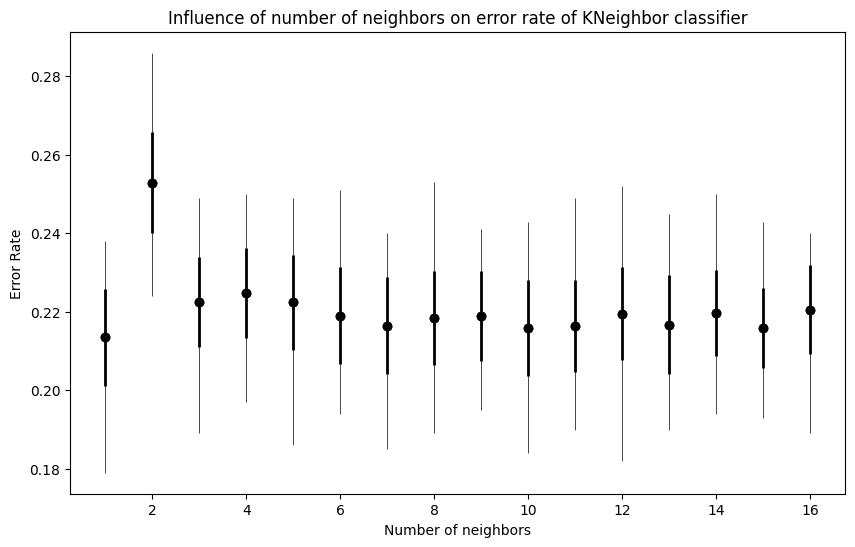

In [9]:
errors = pd.read_csv('./generated/how_many_neighbors_same_sample.csv')

plt.figure(figsize=(10, 6))
#plt.ylim((0.0, 0.5))

plt.errorbar(errors["Number Of Neighbors"], errors["Mean Error Rate On Random Samples"], errors["STD Of Error Rate On Random Samples"], fmt='ok', lw=2)
plt.errorbar(errors["Number Of Neighbors"], errors["Mean Error Rate On Random Samples"], [
    errors["Mean Error Rate On Random Samples"] - errors["Min Error Rate On Random Samples"],
    errors["Max Error Rate On Random Samples"] - errors["Mean Error Rate On Random Samples"]
    ], fmt='ok', lw=0.5)plt.title(label="Influence of number of neighbors on the error rate of KNeighbor classifier")
plt.ylabel(ylabel="Error Rate")
plt.xlabel(xlabel="Number of neighbors")




plt.show()

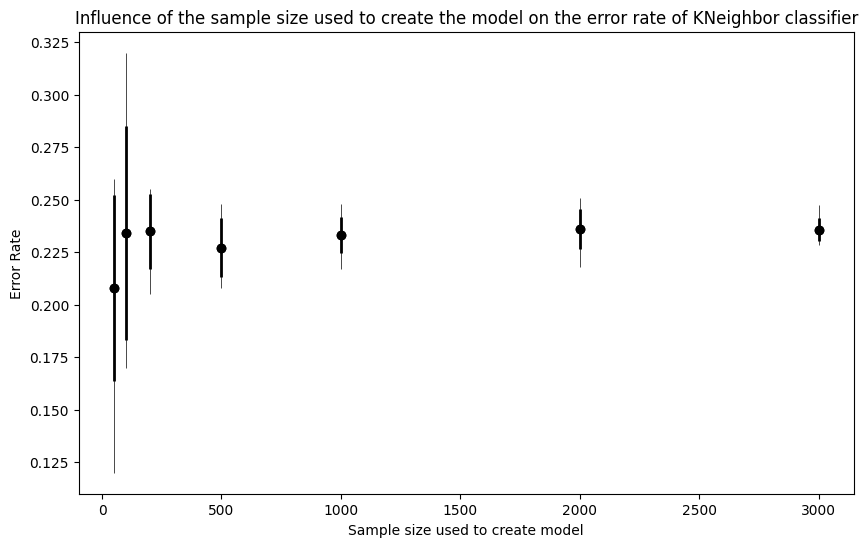

In [10]:
errors = pd.read_csv('./generated/diffent_sample.csv')

plt.figure(figsize=(10, 6))
#plt.ylim((0.0, 0.5))

plt.errorbar(errors["Sample Size"], errors["Mean Error Rate On Random Samples"], errors["STD Of Error Rate On Random Samples"], fmt='ok', lw=2)
plt.errorbar(errors["Sample Size"], errors["Mean Error Rate On Random Samples"], [
    errors["Mean Error Rate On Random Samples"] - errors["Min Error Rate On Random Samples"],
    errors["Max Error Rate On Random Samples"] - errors["Mean Error Rate On Random Samples"]
    ], fmt='ok', lw=0.5)

plt.title(label="Influence of the sample size used to create the model on the error rate of KNeighbor classifier")
plt.ylabel(ylabel="Error Rate")
plt.xlabel(xlabel="Sample size used to create model")

plt.show()